In [1]:
import math
import torch
import gpytorch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import GPE_ensemble as GPE

import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
#from GPErks.gp.data.dataset import Dataset
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from torchmetrics import MeanSquaredError, R2Score
#from GPErks.gp.experiment import GPExperiment
#from GPErks.train.emulator import GPEmulator
#from GPErks.perks.inference import Inference
#from GPErks.train.early_stop import NoEarlyStoppingCriterion
#from GPErks.train.early_stop import (
#    GLEarlyStoppingCriterion,
#    PQEarlyStoppingCriterion,
#    UPEarlyStoppingCriterion,
#)
#from GPErks.train.early_stop import PkEarlyStoppingCriterion



%matplotlib inline
%load_ext autoreload
%autoreload 2

# set logger and enforce reproducibility
#from GPErks.log.logger import get_logger
#from GPErks.utils.random import set_seed
#log = get_logger()
seed = 7
#set_seed(seed)

from time import process_time 
import scipy
from scipy.optimize import minimize

In [2]:
meshes=['01','02','03','04','05','06']

Ys=[]
Xs=[]

for i in range(len(meshes)):
    val=meshes[i]
    
    inputData = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/LA_data/case"+val+"/X.txt",index_col=None,delim_whitespace=True,header=None).values
    outputData = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/LA_data/case"+val+"/Y.txt",index_col=None,delim_whitespace=True,header=None).values

    

    Xs.append(torch.tensor(inputData[0:200]))
    Ys.append(torch.tensor(outputData[0:200]))
    

In [3]:
train_input=[]
test_input = []
train_output=[]
test_output = []
emulators=[]

for i in range(len(meshes)):

    X=Xs[i]
    y=Ys[i]
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=seed+i
    )
    train_input.append(X_train)
    test_input.append(X_test)
    train_output.append(y_train)
    test_output.append(y_test)
    emulator = GPE.ensemble(X_train,y_train,mean_func="linear",training_iter=500)
    emulators.append(emulator)

0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


In [4]:
def proxy_cohort(a,y_test,emulators,x_test,output):
    a=torch.tensor(a)
    res=torch.zeros((y_test.shape[1]))
    m0=torch.zeros(y_test.shape)
    for i in range(len(emulators)):
        m0+=a[i]*emulators[i].predict(x_test)
    res += ((m0-y_test)**2).mean(axis=0).detach().numpy()
    return res[output]

In [5]:
def proxy(a,y_train,m0,output):
    a=torch.tensor(a)
    res = ((a*m0-y_train)**2).mean(axis=0).detach().numpy()
    return res[output]

In [6]:
def m0_mat(y_test,emulators,x_test,output):
    res=torch.zeros((y_test.shape[1]))
    m0=torch.zeros((y_test.shape[0],len(emulators)))
    for i in range(len(emulators)):
        m0[:,i]=emulators[i].predict(x_test)[:,output]

    return m0

In [7]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score


In [8]:
model = Pipeline(steps=[
    #('scaler', StandardScaler()),
    ('preprocessor', PolynomialFeatures(degree=1, include_bias=False,interaction_only=False)),
    ('lasso', LassoCV(n_alphas=10,max_iter=1000))
])

In [9]:
import time

In [10]:
R2=torch.zeros(7,7)
Ti=torch.zeros(7)
reps=10
n=40

for k in range(len(emulators)):
    emulators2=emulators.copy()
    emulators2.pop(k)
#     print(len(emulators2))
#     X_train, X_test, y_train, y_test = train_test_split(
#                 Xs[k].float(),
#                 Ys[k].float(),
#                 test_size=0.1,
#                 random_state=seed
#             )
    X_train=train_input[k]
    X_test=test_input[k]
    y_train=train_output[k]
    y_test=test_output[k]
    for i in range(reps):

        b=np.random.choice(range(X_train.shape[0]),n,replace=False)

        start = time.time()
        model_f=GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="linear",training_iter=500)
        R2[0]+=model_f.R2(X_test,y_test)/(reps*len(emulators))
        end = time.time()
        Ti[0]+=(end-start)/(reps*len(emulators))

        start = time.time()
        em=np.random.randint(len(emulators2))
        model_dc_1 = GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="discrepancy_cohort",training_iter=500,ref_emulator=[emulators2[em]],a=torch.tensor([[1],[1],[1],[1],[1],[1],[1]]))
        R2[1]+=model_dc_1.R2(X_test,y_test)/(reps*len(emulators))
        print(model_dc_1.R2(X_test,y_test))
        print(R2[1])
        end = time.time()
        Ti[1]+=(end-start)/(reps*len(emulators))

        start = time.time()
        m0 = emulators2[0].predict(X_train[b,:])
        a_d=np.zeros((y_train.shape[1],1))
        for l in range(y_train.shape[1]):
            result = scipy.optimize.minimize(proxy, 1, args=(y_train[b,:],m0,l), method='Nelder-Mead', tol=1e-8)
            print(result.x)
            a_d[l]=result.x
        a_d=torch.tensor(a_d)
        model_dc_reg = GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="discrepancy_cohort",training_iter=500,ref_emulator=[emulators2[0]],a=a_d)
        R2[2]+=model_dc_reg.R2(X_test,y_test)/(reps*len(emulators))
        end = time.time()
        Ti[2]+=(end-start)/(reps*len(emulators))

        start = time.time()
        model_dc_learned = GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="discrepancy_cohort",training_iter=500,ref_emulator=[emulators2[0]])
        R2[3]+=model_dc_learned.R2(X_test,y_test)/(reps*len(emulators))
        end = time.time()
        Ti[3]+=(end-start)/(reps*len(emulators))

        start = time.time()
        model_dc_all = GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="discrepancy_cohort",training_iter=500,ref_emulator=emulators2)
        R2[4]+=model_dc_all.R2(X_test,y_test)/(reps*len(emulators))
        end = time.time()
        Ti[4]+=(end-start)/(reps*len(emulators))

        start = time.time()
        a_d=torch.zeros((y_train.shape[1],len(emulators2)))
        for i in range(y_train.shape[1]):
            m0=m0_mat(y_train[b],emulators2,X_train[b],i)
            # fit to an order-3 polynomial data
            model = model.fit(m0.detach().numpy(), y_train[b,i].detach().numpy())
            a_d[i]=torch.tensor(model.named_steps['lasso'].coef_)


        model_dc_lasso=GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="discrepancy_cohort",training_iter=500,ref_emulator=emulators2,a=a_d)
        R2[5]+=model_dc_lasso.R2(X_test,y_test)/(reps*len(emulators))
        end = time.time()
        Ti[5]+=(end-start)/(reps*len(emulators))

        start = time.time()
        model_dc_lasso_learned=GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="discrepancy_cohort",training_iter=500,ref_emulator=emulators2,a=a_d,a_indicator=True)
        R2[6]+=model_dc_lasso_learned.R2(X_test,y_test)/(reps*len(emulators))
        end = time.time()
        Ti[6]+=(end-start)/(reps*len(emulators))

0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.8121, 0.7948, 0.6031, 0.5557, 0.7039, 0.6394, 0.9324],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([0.0135, 0.0132, 0.0101, 0.0093, 0.0117, 0.0107, 0.0155],
       grad_fn=<SelectBackward0>)
[1.08361981]
[1.02671457]
[1.24556696]
[1.13751057]
[1.17633855]
[0.70895218]
[0.54807907]
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.8213, 0.3713, 0.6215, 0.8653, 0.6316, 0.5749, 0.9016],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([0.0272, 0.0194, 0.0204, 0.0237, 0.0223, 0.0202, 0.0306],
       grad_fn=<SelectBackward0>)
[1.12507396]
[1.02281766]
[1.27031432]
[1.14626601]
[1.1519251]
[0.75224249]
[0.54889968]
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.8581, 0.4719, 0.8931, 0.8343, 0.6011, 0.6847, 0.9455],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([0.0415, 0.0273, 0.0353, 0.0376, 0.0

1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.9191, 0.8799, 0.9148, 0.9344, 0.8932, 0.7544, 0.9555],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([0.2994, 0.2344, 0.2535, 0.3094, 0.2497, 0.2397, 0.3354],
       grad_fn=<SelectBackward0>)
[0.86276592]
[1.11058639]
[0.70057363]
[0.88371006]
[0.66896592]
[1.0053298]
[2.13739715]
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.8897, 0.8521, 0.6283, 0.6422, 0.8549, 0.8283, 0.9644],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([0.3143, 0.2486, 0.2640, 0.3201, 0.2639, 0.2535, 0.3514],
       grad_fn=<SelectBackward0>)
[0.86476997]
[1.11379957]
[0.72508988]
[0.84054422]
[0.67052819]
[0.99644213]
[2.14863319]
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.8546, 0.8995, 0.4613, 0.9045, 0.8044, 0.7685, 0.9467],
       dtype=torch.float64, 

3
4
5
6
tensor([0.7100, 0.7356, 0.5675, 0.7349, 0.8427, 0.2203, 0.9449],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([0.5665, 0.4799, 0.4882, 0.5603, 0.5060, 0.4712, 0.6445],
       grad_fn=<SelectBackward0>)
[1.05749087]
[1.65486524]
[0.63228916]
[0.88637745]
[1.01821358]
[1.02656763]
[1.22680752]
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.8306, 0.7755, 0.4450, 0.8746, 0.5292, 0.7749, 0.9665],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([0.5803, 0.4929, 0.4957, 0.5748, 0.5148, 0.4841, 0.6606],
       grad_fn=<SelectBackward0>)
[1.03656918]
[1.65648072]
[0.61890795]
[0.89660161]
[1.01693965]
[0.8227114]
[1.21083924]
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
tensor([0.8523, 0.6632, 0.6079, 0.8483, 0.5320, 0.7140, 0.9459],
       dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([0.5945, 0.5039, 0.5058, 0.5890, 0.5237, 0.4960, 0.6763]

In [11]:
k

5

In [12]:
emulators

In [13]:
model_dc_lasso.R2(X_test,y_test)/(reps*len(emulators))

tensor([0.0146, 0.0143, 0.0146, 0.0161, 0.0138, 0.0117, 0.0162],
       dtype=torch.float64, grad_fn=<DivBackward0>)

In [14]:
y_labels

NameError: name 'y_labels' is not defined

In [15]:
R2.shape

torch.Size([7, 7])

In [16]:
y_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/LA_data/case01/ylabels.txt',delim_whitespace=True,header=None)
x_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/LA_data/case01/xlabels.txt',delim_whitespace=True,header=None)



In [17]:
ynames=y_labels.copy().values.squeeze().tolist()

In [18]:
ynames.append('Time')

In [19]:
ynames

['d_global',
 'd_anterior',
 'd_posterior',
 'd_septum',
 'd_lateral',
 'd_roof',
 'ESV',
 'Time']

In [20]:
results=pd.DataFrame(torch.cat((R2.T,Ti[None])).T.detach().numpy())

results.index=['$f_1$','$\delta_1$, a=1','$\delta_1$, regression a','$\delta_1$, learned a','$\delta_c$, all','$\delta_c$, lasso','$\delta_c$, lasso indicator']

results.columns=ynames

results.style.highlight_min(color = 'pink', axis = 0).highlight_max(color = 'lightgreen', axis = 0)

,d_global,d_anterior,d_posterior,d_septum,d_lateral,d_roof,ESV,Time
$f_1$,0.731039,0.668631,0.640582,0.704406,0.724947,0.608608,0.863877,3.776792
"$\delta_1$, a=1",0.821777,0.724544,0.700669,0.819193,0.717572,0.676052,0.928223,15.809414
"$\delta_1$, regression a",0.840658,0.681226,0.665479,0.800010,0.733078,0.615348,0.892920,17.967564
"$\delta_1$, learned a",0.849143,0.758111,0.736209,0.814620,0.783432,0.669503,0.897080,17.771280
"$\delta_c$, all",0.881536,0.842410,0.798019,0.876859,0.811497,0.772057,0.949703,97.776237
"$\delta_c$, lasso",0.833814,0.789670,0.726326,0.837552,0.783027,0.671431,0.942562,77.300713
"$\delta_c$, lasso indicator",0.878024,0.841258,0.798877,0.885048,0.820374,0.780691,0.948388,74.700119


In [ ]:
results

In [ ]:
x_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/LA_data/case01/xlabels.txt',delim_whitespace=True,header=None)

y_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/LA_data/case01/ylabels.txt',delim_whitespace=True,header=None)


meshes=['01','02','03','04','05','06']

meshes.copy

t_size = 60
ts = 9
reps = 5
MSE_i = np.zeros((len(meshes),7,9))
R2_i = np.zeros((len(meshes),7,9))

for i in (range(len(meshes))):
    val0 = meshes[i]

    meshes2 = meshes.copy()
    meshes2.remove(meshes[i])

    inputData_0 = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/LA_data/case"+val0+"/X.txt",index_col=None,delim_whitespace=True,header=None).values
    outputData_0 = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/LA_data/case"+val0+"/Y.txt",index_col=None,delim_whitespace=True,header=None).values

    X0 = torch.tensor(inputData_0)[0:200]
    Y0 = torch.tensor(outputData_0)[0:200]
    X0.columns = x_labels
    Y0.columns = y_labels
    
    
    X_train, X_test, y_train, y_test = train_test_split(
                X0,
                Y0,
                test_size=0.1,
                random_state=seed
            )
    
    for l in range(ts):
        t_size = 20*(l+1)


        for k in range(reps):
            a=np.random.choice(range(X_train.shape[0]),t_size,replace=False)

            emulator = GPE.ensemble(X_train[a,:],y_train[a,:],mean_func="linear",training_iter=1000)
            MSE_i[i,:,l] += emulator.MSE(X_test,y_test).detach().numpy()/reps
            R2_i[i,:,l] += emulator.R2(X_test,y_test).detach().numpy()/reps



([<matplotlib.axis.XTick at 0x2b241bb90>,
 [Text(0, 0, '01'),
  Text(1, 0, '02'),
  Text(2, 0, '03'),
  Text(3, 0, '04'),
  Text(4, 0, '05'),
  Text(5, 0, '06')])

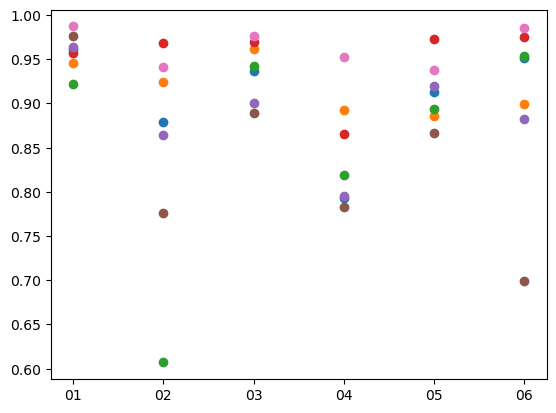

In [46]:
plt.plot(R2_i[:,:,8],'o')
plt.xticks(range(len(meshes)),meshes)

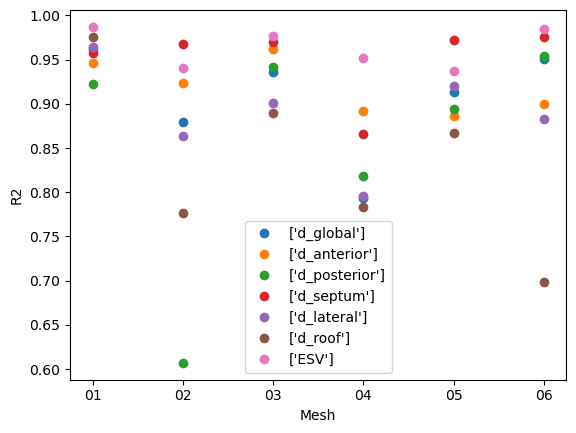

In [51]:
plt.plot(R2_i[:,:,8],'o')
plt.xticks(range(len(meshes)),meshes)
plt.ylabel('R2')
plt.xlabel('Mesh')
plt.legend(y_labels.values)

Text(0, 0.5, '$R^2$')

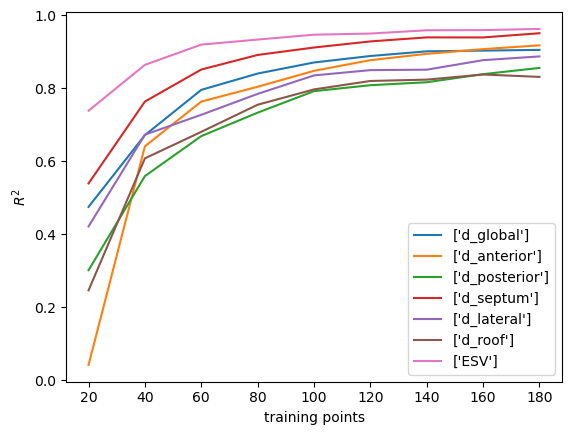

In [57]:
plt.plot(np.linspace(20,180,9),R2_i[:,:,:].T.mean(axis=2))
plt.legend(y_labels.values)
plt.xlabel('training points')
plt.ylabel('$R^2$')

In [7]:
emulator.MSE(X_test,y_test)

tensor([ 0.3130,  0.3869,  0.2734,  0.7547,  0.4779,  0.5911, 38.5422],
       dtype=torch.float64, grad_fn=<MeanBackward1>)

In [94]:
x_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/LA_data/case01/xlabels.txt',delim_whitespace=True,header=None)

y_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/LA_data/case01/ylabels.txt',delim_whitespace=True,header=None)


meshes=['01','02','03','04','05','06']

meshes.copy

t_size = 60
ts = 9
reps = 5
MSE_disc = np.zeros((len(meshes),len(meshes)-1,7,9))
R2_disc = np.zeros((len(meshes),len(meshes)-1,7,9))

for i in (range(len(meshes))):
    val0 = meshes[i]

    meshes2 = meshes.copy()
    meshes2.remove(meshes[i])

    inputData_0 = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/LA_data/case"+val0+"/X.txt",index_col=None,delim_whitespace=True,header=None).values
    outputData_0 = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/LA_data/case"+val0+"/Y.txt",index_col=None,delim_whitespace=True,header=None).values

    X0 = torch.tensor(inputData_0)[0:200]
    Y0 = torch.tensor(outputData_0)[0:200]
    X0.columns = x_labels
    Y0.columns = y_labels
    emulator_0 = GPE.ensemble(X0,Y0,mean_func="linear",training_iter=500)

    for l in range(ts):
        t_size = 20*(l+1)

        for j in (range(len(meshes)-1)):
            val1 = meshes2[j]
            inputData_1 = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/LA_data/case"+val1+"/X.txt",index_col=None,delim_whitespace=True,header=None).values
            outputData_1 = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/LA_data/case"+val1+"/Y.txt",index_col=None,delim_whitespace=True,header=None).values

            X1 = torch.tensor(inputData_1)[0:200]
            Y1 = torch.tensor(outputData_1)[0:200]
            X1.columns = x_labels
            Y1.columns = y_labels
            # split original dataset in training, validation and testing sets
            X_train, X_test, y_train, y_test = train_test_split(
                X1,
                Y1,
                test_size=0.1,
                random_state=seed
            )
            for k in range(reps):
                a=np.random.choice(range(X_train.shape[0]),t_size,replace=False)
                m0 = emulator_0.predict(X_train[a,:])
                y_adjust = torch.tensor(y_train[a] - m0)
                delta_1 = GPE.ensemble(X_train[a,:],y_adjust,mean_func="linear",training_iter=500)
                MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
                R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps



0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_disc[i,j,:,l] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/190911210.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_disc[i,j,:,l] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


In [95]:
y_labels

,0
0,d_global
1,d_anterior
2,d_posterior
3,d_septum
4,d_lateral
5,d_roof
6,ESV


In [96]:
R2_disc

array([[[[ 0.8311729 ,  0.84585973,  0.86835805, ...,  0.89365522,
           0.89764126,  0.91319561],
         [ 0.79852512,  0.85825916,  0.89168898, ...,  0.93332384,
           0.94565663,  0.95136546],
         [ 0.37956059,  0.55119695,  0.55410297, ...,  0.63069528,
           0.60911825,  0.65116575],
         ...,
         [-0.04442466,  0.10814213,  0.42143565, ...,  0.6236775 ,
           0.63754131,  0.70192009],
         [ 0.48131736,  0.5618807 ,  0.69396542, ...,  0.74090863,
           0.74423999,  0.7723593 ],
         [ 0.83821362,  0.89173929,  0.93383559, ...,  0.94190599,
           0.94541912,  0.95056026]],

        [[ 0.88645745,  0.92292254,  0.93116125, ...,  0.93254868,
           0.91716842,  0.92521701],
         [ 0.8398686 ,  0.91205488,  0.93277946, ...,  0.95768924,
           0.94921604,  0.96432888],
         [ 0.74346901,  0.87179871,  0.87231452, ...,  0.9277978 ,
           0.93468608,  0.95936301],
         ...,
         [ 0.81341017,  0.81621906

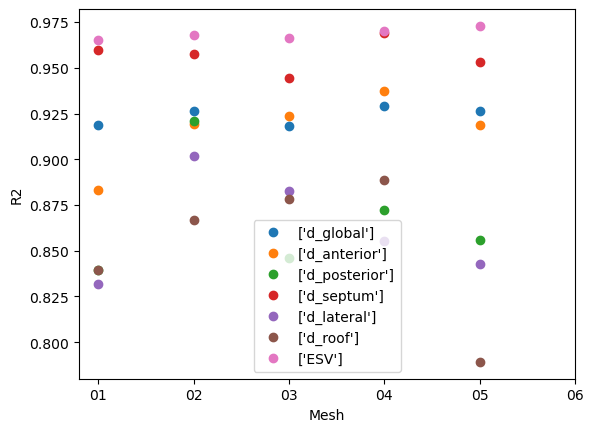

In [97]:
plt.plot(R2_disc[:5,:,:,8].mean(axis=1),'o')
plt.xticks(range(len(meshes)),meshes)
plt.ylabel('R2')
plt.xlabel('Mesh')
plt.legend(y_labels.values)

In [107]:
R2_disc[7,:,:,:].mean(axis=(0,1)).shape

IndexError: index 7 is out of bounds for axis 0 with size 6

Text(0, 0.5, '$R^2$')

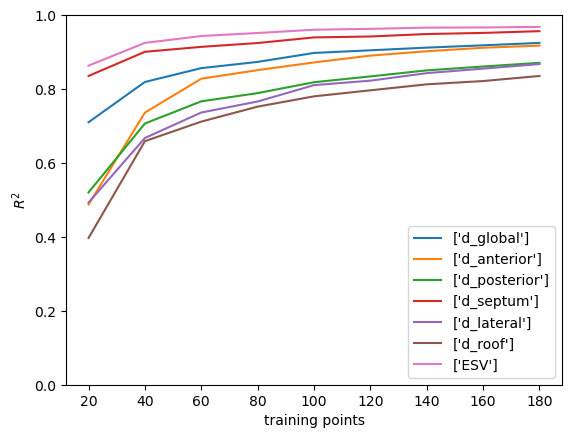

In [108]:
plt.plot(np.linspace(20,180,9),R2_disc[0:6,:,:,:].mean(axis=(0,1)).T)
plt.legend(y_labels.values,loc='lower right')
plt.ylim(0,1)
plt.xlabel('training points')
plt.ylabel('$R^2$')

In [100]:
np.linspace(20,180,9)

array([ 20.,  40.,  60.,  80., 100., 120., 140., 160., 180.])

In [101]:
R2_disc[:,:,0,:].mean(axis=1).shape

(6, 9)

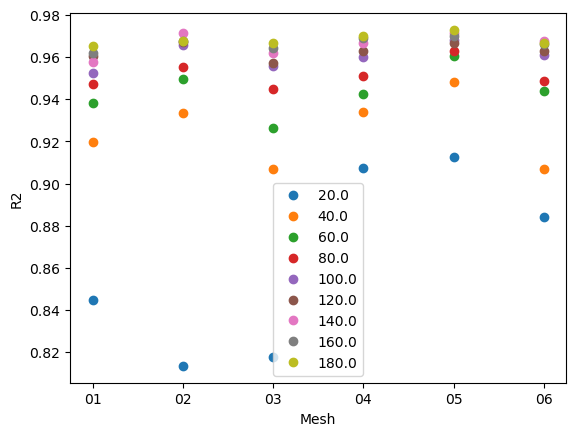

In [102]:
plt.plot(R2_disc[:,:,6,:].mean(axis=1),'o')
plt.xticks(range(len(meshes)),meshes)
plt.ylabel('R2')
plt.xlabel('Mesh')
plt.legend(np.linspace(20,180,9))

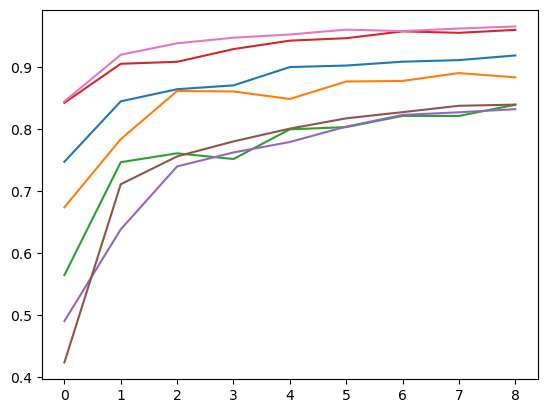

In [103]:
plt.plot(R2_disc[0,:,:,:].mean(axis=0).T)

In [31]:
inputData_0 = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/LA_data/case01/X.txt",index_col=None,delim_whitespace=True,header=None).values
outputData_0 = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/LA_data/case01/Y.txt",index_col=None,delim_whitespace=True,header=None).values

inputData_1 = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/LA_data/case02/X.txt",index_col=None,delim_whitespace=True,header=None).values
outputData_1 = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/LA_data/case02/Y.txt",index_col=None,delim_whitespace=True,header=None).values

X0 = torch.tensor(inputData_0)[0:200]
Y0 = torch.tensor(outputData_0)[0:200]

X1 = torch.tensor(inputData_1)[0:200]
Y1 = torch.tensor(outputData_1)[0:200]



emulator_0 = GPE.ensemble(X0,Y0,mean_func="constant",training_iter=0)

for param in emulator_0.models[0].named_parameters():
    print(f' value = {param}')

emulator_0 = GPE.ensemble(X0,Y0,mean_func="linear",training_iter=500)

for param in emulator_0.models[0].named_parameters():
    print(f' value = {param}')

# split original dataset in training, validation and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X1,
    Y1,
    test_size=0.1,
    random_state=seed
)

X_test.shape[1]

a=np.random.choice(range(X_train.shape[0]),18,replace=False)

X_train

X_train.shape

m0 = emulator_0.predict(X_train[a])

y_adjust = torch.tensor(y_train[a] - m0)

delta_1 = GPE.ensemble(X_train[a],y_adjust,mean_func="linear",training_iter=500)

((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()

1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-y_test)**2).mean(axis=0)/y_test.var(axis=0)



p = int(X1.shape[0]*0.05)
n = int(X_train.shape[0]/p)
reps = 5
MSE = np.zeros((n,reps,7))
R2 = np.zeros((n,reps,7))
MSE_p = np.zeros((n,reps,7))
R2_p = np.zeros((n,reps,7))
for i in range(n):
    for j in range(reps):
        a=np.random.choice(range(X_train.shape[0]),(i+1)*p,replace=False)
        m0 = emulator_0.predict(X_train[a,:])
        y_adjust = torch.tensor(y_train[a] - m0)
        delta_1 = GPE.ensemble(X_train[a,:],y_adjust,mean_func="linear",training_iter=500)
        MSE[i,j] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()
        R2[i,j] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-y_test)**2).mean(axis=0)/y_test.var(axis=0)).detach().numpy()
        
        delta_1p = GPE.ensemble(X_train[a,:],y_train[a],mean_func="linear",training_iter=500)
        MSE_p[i,j] += delta_1p.MSE(X_test,y_test).detach().numpy()
        R2_p[i,j] += delta_1p.R2(X_test,y_test).detach().numpy()

0
1
2
3
4
5
6
 value = ('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([0.], requires_grad=True))
 value = ('mean_module.raw_constant', Parameter containing:
tensor(0., requires_grad=True))
 value = ('covar_module.raw_outputscale', Parameter containing:
tensor(0., requires_grad=True))
 value = ('covar_module.base_kernel.raw_lengthscale', Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0.]], requires_grad=True))
0
1
2
3
4
5
6
 value = ('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([-4.4365], requires_grad=True))
 value = ('mean_module.weights', Parameter containing:
tensor([[-0.8670],
        [ 0.0298],
        [-0.0577],
        [-0.0081],
        [-0.2185],
        [-0.8418],
        [ 0.5087],
        [-0.0793],
        [-0.0588]], requires_grad=True))
 value = ('mean_module.bias', Parameter containing:
tensor([2.2194], requires_grad=True))
 value = ('covar_module.raw_outputscale', Parameter containing:
tensor(1.6063, requires_grad=

/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/2373241405.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/2373241405.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/2373241405.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2
3
4
5
6


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_73217/2373241405.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE[i,j] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()


0
1
2
3
4
5
6


/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:205: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_score=1-self.MSE(inputVals,outputVals)/torch.tensor(torch.var(outputVals,axis=0))


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2


In [32]:
p

10

In [33]:
n

18

In [34]:
X_train.shape

torch.Size([180, 9])

In [35]:
x = np.linspace(20,180,18)

In [36]:
x

array([ 20.        ,  29.41176471,  38.82352941,  48.23529412,
        57.64705882,  67.05882353,  76.47058824,  85.88235294,
        95.29411765, 104.70588235, 114.11764706, 123.52941176,
       132.94117647, 142.35294118, 151.76470588, 161.17647059,
       170.58823529, 180.        ])

Text(0.5, 0, '$m$')

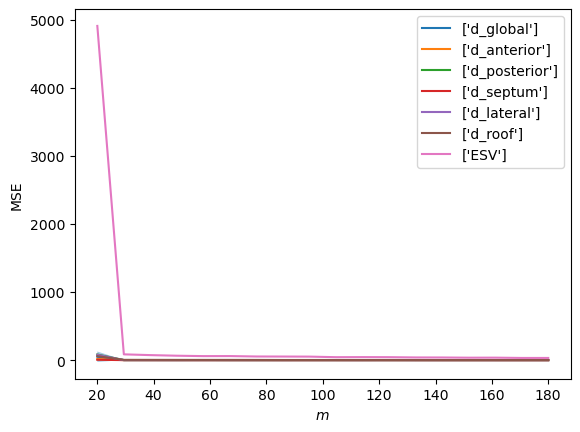

In [37]:
plt.plot(x,MSE.mean(axis=1))
plt.fill_between(x, MSE.mean(axis=1)[:,0]+MSE.std(axis=1)[:,0], y2=MSE.mean(axis=1)[:,0]-MSE.std(axis=1)[:,0],alpha=0.4)
plt.fill_between(x, MSE.mean(axis=1)[:,1]+MSE.std(axis=1)[:,1], y2=MSE.mean(axis=1)[:,1]-MSE.std(axis=1)[:,1],alpha=0.4)
plt.legend(y_labels.values)

plt.ylabel('MSE')
plt.xlabel('$m$')
#plt.yscale('log')


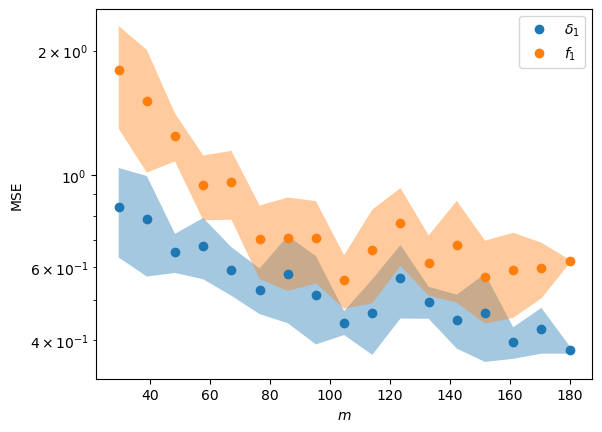

In [38]:
plt.plot(x[1:],np.hstack((MSE.mean(axis=1),MSE_p.mean(axis=1)))[1:,[0,7]],'o') 
plt.fill_between(x[1:], MSE.mean(axis=1)[1:,0]+MSE.std(axis=1)[1:,0], y2=MSE.mean(axis=1)[1:,0]-MSE.std(axis=1)[1:,0],alpha=0.4)
plt.fill_between(x[1:], MSE_p.mean(axis=1)[1:,0]+MSE_p.std(axis=1)[1:,0], y2=MSE_p.mean(axis=1)[1:,0]-MSE_p.std(axis=1)[1:,0],alpha=0.4)
plt.legend(['$\delta_1$','$f_1$'])
plt.ylabel('MSE')
plt.xlabel('$m$')
plt.yscale('log')

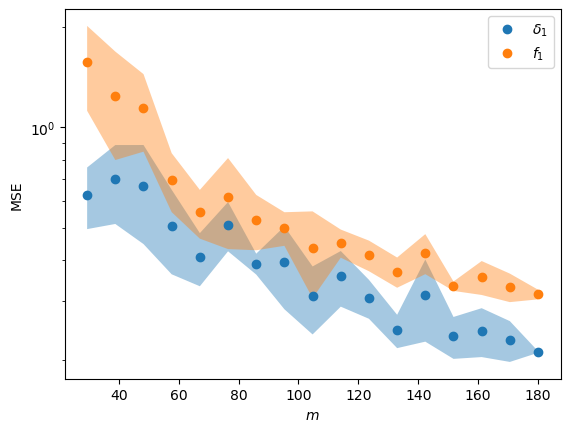

In [39]:
plt.plot(x[1:],np.hstack((MSE.mean(axis=1),MSE_p.mean(axis=1)))[1:,[1,8]],'o') 
plt.fill_between(x[1:], MSE.mean(axis=1)[1:,1]+MSE.std(axis=1)[1:,1], y2=MSE.mean(axis=1)[1:,1]-MSE.std(axis=1)[1:,1],alpha=0.4)
plt.fill_between(x[1:], MSE_p.mean(axis=1)[1:,1]+MSE_p.std(axis=1)[1:,1], y2=MSE_p.mean(axis=1)[1:,1]-MSE_p.std(axis=1)[1:,1],alpha=0.4)
plt.legend(['$\delta_1$','$f_1$'])
plt.ylabel('MSE')
plt.xlabel('$m$')
plt.yscale('log')

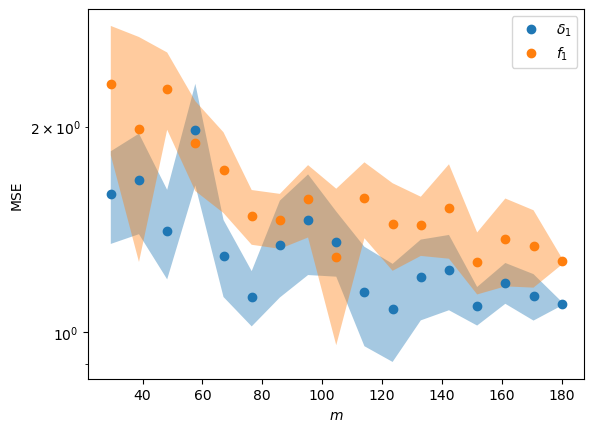

In [40]:
plt.plot(x[1:],np.hstack((MSE.mean(axis=1),MSE_p.mean(axis=1)))[1:,[2,9]],'o') 
plt.fill_between(x[1:], MSE.mean(axis=1)[1:,2]+MSE.std(axis=1)[1:,2], y2=MSE.mean(axis=1)[1:,2]-MSE.std(axis=1)[1:,2],alpha=0.4)
plt.fill_between(x[1:], MSE_p.mean(axis=1)[1:,2]+MSE_p.std(axis=1)[1:,2], y2=MSE_p.mean(axis=1)[1:,2]-MSE_p.std(axis=1)[1:,2],alpha=0.4)
plt.legend(['$\delta_1$','$f_1$'])
plt.ylabel('MSE')
plt.xlabel('$m$')
plt.yscale('log')

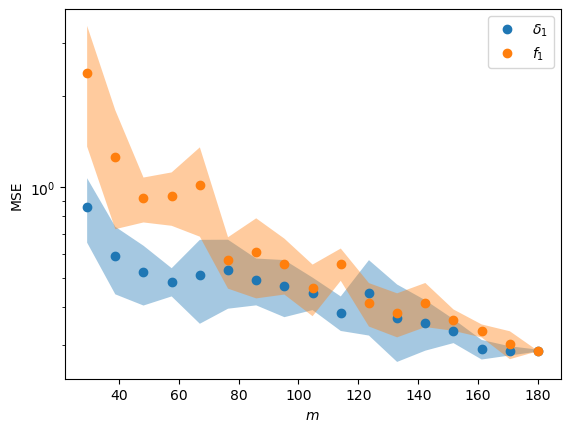

In [41]:
plt.plot(x[1:],np.hstack((MSE.mean(axis=1),MSE_p.mean(axis=1)))[1:,[3,10]],'o') 
plt.fill_between(x[1:], MSE.mean(axis=1)[1:,3]+MSE.std(axis=1)[1:,3], y2=MSE.mean(axis=1)[1:,3]-MSE.std(axis=1)[1:,3],alpha=0.4)
plt.fill_between(x[1:], MSE_p.mean(axis=1)[1:,3]+MSE_p.std(axis=1)[1:,3], y2=MSE_p.mean(axis=1)[1:,3]-MSE_p.std(axis=1)[1:,3],alpha=0.4)
plt.legend(['$\delta_1$','$f_1$'])
plt.ylabel('MSE')
plt.xlabel('$m$')
plt.yscale('log')

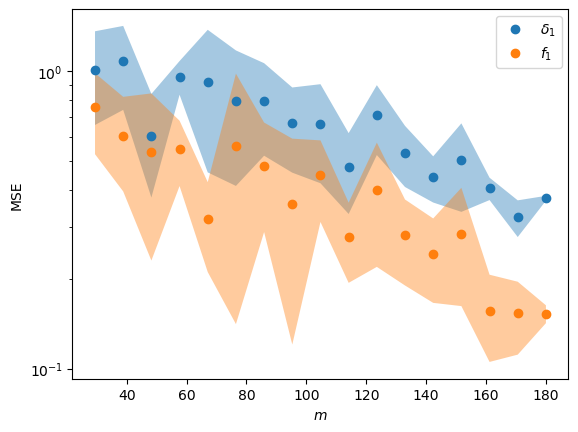

In [42]:
plt.plot(x[1:],np.hstack((MSE.mean(axis=1),MSE_p.mean(axis=1)))[1:,[4,11]],'o') 
plt.fill_between(x[1:], MSE.mean(axis=1)[1:,4]+MSE.std(axis=1)[1:,4], y2=MSE.mean(axis=1)[1:,4]-MSE.std(axis=1)[1:,4],alpha=0.4)
plt.fill_between(x[1:], MSE_p.mean(axis=1)[1:,4]+MSE_p.std(axis=1)[1:,4], y2=MSE_p.mean(axis=1)[1:,4]-MSE_p.std(axis=1)[1:,4],alpha=0.4)
plt.legend(['$\delta_1$','$f_1$'])
plt.ylabel('MSE')
plt.xlabel('$m$')
plt.yscale('log')

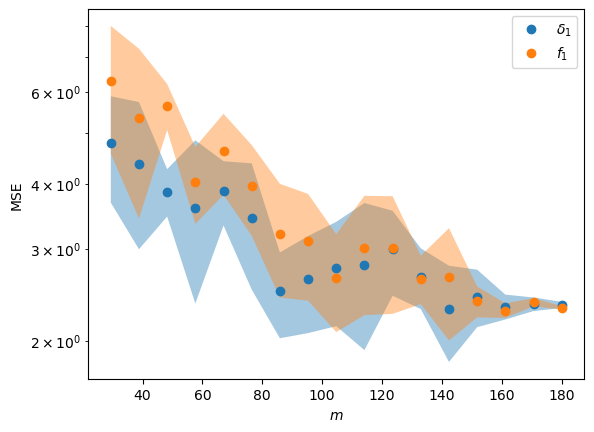

In [43]:
plt.plot(x[1:],np.hstack((MSE.mean(axis=1),MSE_p.mean(axis=1)))[1:,[5,12]],'o') 
plt.fill_between(x[1:], MSE.mean(axis=1)[1:,5]+MSE.std(axis=1)[1:,5], y2=MSE.mean(axis=1)[1:,5]-MSE.std(axis=1)[1:,5],alpha=0.4)
plt.fill_between(x[1:], MSE_p.mean(axis=1)[1:,5]+MSE_p.std(axis=1)[1:,5], y2=MSE_p.mean(axis=1)[1:,5]-MSE_p.std(axis=1)[1:,5],alpha=0.4)
plt.legend(['$\delta_1$','$f_1$'])
plt.ylabel('MSE')
plt.xlabel('$m$')
plt.yscale('log')

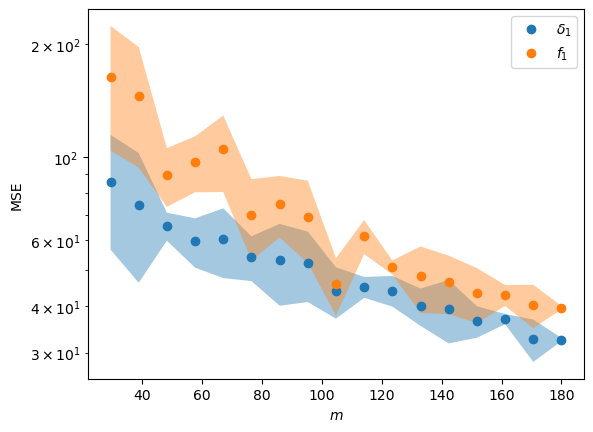

In [44]:
plt.plot(x[1:],np.hstack((MSE.mean(axis=1),MSE_p.mean(axis=1)))[1:,[6,13]],'o') 
plt.fill_between(x[1:], MSE.mean(axis=1)[1:,6]+MSE.std(axis=1)[1:,6], y2=MSE.mean(axis=1)[1:,6]-MSE.std(axis=1)[1:,6],alpha=0.4)
plt.fill_between(x[1:], MSE_p.mean(axis=1)[1:,6]+MSE_p.std(axis=1)[1:,6], y2=MSE_p.mean(axis=1)[1:,6]-MSE_p.std(axis=1)[1:,6],alpha=0.4)
plt.legend(['$\delta_1$','$f_1$'])
plt.ylabel('MSE')
plt.xlabel('$m$')
plt.yscale('log')

In [ ]:
#b=np.random.choice(range(X_train.shape[0]),18,replace=False)
p = int(X0.shape[0]*0.05)
n = int(X0.shape[0]/p)
m = 18
MSE_mn = np.zeros((n,m,7))
R2_mn = np.zeros((n,m,7))
reps = 5
for i in range(n):
    for k in range(m):
        for j in range(reps):
            b=np.random.choice(range(X_train.shape[0]),(k+1)*p,replace=False)
            a=np.random.choice(range(X0.shape[0]),(i+1)*p,replace=False)
            emulator_0 = GPE.ensemble(X0[a,:],Y0[a,:],mean_func="linear",training_iter=500)
            m0 = emulator_0.predict(X_train[b,:])
            y_adjust = torch.tensor(y_train[b] - m0)
            delta_1 = GPE.ensemble(X_train[b,:],y_adjust,mean_func="linear",training_iter=500)
            MSE_mn[i,k] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
            R2_mn[i,k] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


In [ ]:
x

y = np.linspace(9,180,20)

y

xx,yy=np.meshgrid(x,y)

xx[1:,1:].shape

level = 1

plt.contourf(xx[level:,level:],yy[level:,level:],R2_mn[level:,level:,0],origin='lower',levels=50)
plt.ylabel('n')
plt.xlabel('m')
plt.colorbar()

In [ ]:
import scipy

In [ ]:
def proxy(a,y_train,m0,output):
    a=torch.tensor(a)
    res = ((a*m0-y_train)**2).mean(axis=1).detach().numpy()
    return res[output]

In [ ]:
#b=np.random.choice(range(X_train.shape[0]),18,replace=False)
p = int(X0.shape[0]*0.05)
n = int(X0.shape[0]/p)
m = 18
MSE_a = np.zeros((n,m,7))
R2_a = np.zeros((n,m,7))
reps = 5
for i in range(n):
    for k in range(m):
        for j in range(reps):
            b=np.random.choice(range(X_train.shape[0]),(k+1)*p,replace=False)
            a=np.random.choice(range(X0.shape[0]),(i+1)*p,replace=False)
            
            emulator_0 = GPE.ensemble(X0[a,:],Y0[a,:],mean_func="linear",training_iter=500)
            m0 = emulator_0.predict(X_train[b,:])
            
            a_d=np.zeros(y_train.shape[1])
            for l in range(y_train.shape[1]):
                result = scipy.optimize.minimize(proxy, 1, args=(y_train[b,:],m0,l), method='Nelder-Mead', tol=1e-8)
                print(result.x)
                a_d[l]=result.x

            a_d=torch.tensor(a_d)
            print(a_d)
            
            
            y_adjust = torch.tensor(y_train[b] - a_d*m0)
            delta_1 = GPE.ensemble(X_train[b,:],y_adjust,mean_func="linear",training_iter=500)
            MSE_a[i,k] += np.sqrt(((a_d*emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
            R2_a[i,k] += (1-((a_d*emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


In [ ]:
x

y = np.linspace(9,180,20)

y

xx,yy=np.meshgrid(x,y)

xx[1:,1:].shape

level = 1

plt.contourf(xx[level:,level:],yy[level:,level:],R2_a[level:,level:,0],origin='lower',levels=50)
plt.ylabel('n')
plt.xlabel('m')
plt.colorbar()

# Emulator

In [ ]:
y_train = torch.tensor(y_all.values[0:200])
x_train = torch.tensor(X_all.values[0:200])

In [ ]:
emulator = GPE.ensemble(x_train,y_train,mean_func="linear",training_iter=500)

In [ ]:
y_train[100]

In [ ]:
nDim = X_all.shape[1]
boundsMaxMin = []
for i in range(nDim):
    boundsMaxMin.append([np.min(X_all.iloc[:,i]),np.max(X_all.iloc[:,i])])
    print(boundsMaxMin[i])

In [ ]:
centre = (np.array(boundsMaxMin)[:,1]+np.array(boundsMaxMin)[:,0])/2

In [ ]:
import emcee
ndim = nDim
nwalkers = 18
p0 = np.random.multivariate_normal(centre, 0.000000001*np.identity(ndim), size=(nwalkers))
y_val = y_train[100]

In [ ]:
boundsMaxMin

In [ ]:
np.array(boundsMaxMin)[:,0]*2

In [ ]:
p0[0]

In [ ]:
def log_prior(theta):
    
    #if (np.array(boundsMaxMin)[:,0]<theta).all() and (theta<np.array(boundsMaxMin)[:,1]).all():
        
    if (np.array(boundsMaxMin)[:,0]*0.5<theta).all() and (theta<np.array(boundsMaxMin)[:,1]*2).all():
        return 0.0
    return -np.inf

In [ ]:
def log_prior(theta):
    
    #if (np.array(boundsMaxMin)[:,0]<theta).all() and (theta<np.array(boundsMaxMin)[:,1]).all():
        
    if (np.array(boundsMaxMin)[:,0]<theta).all() and (theta<np.array(boundsMaxMin)[:,1]).all():
        return 0.0
    return -np.inf

In [ ]:
x=torch.tensor(p0[0])[None]
ll =np.sum(emulator.ensemble_log_likelihood_obs_error(x,y_val[None,:],torch.ones(9)*0.01).detach().numpy())

In [ ]:
def log_likelihood(x,emulator,y_val):
    x=torch.tensor(x)[None]
    ll =np.sum((emulator.ensemble_log_likelihood_obs_error(x,y_val[None,:],[0.01,0.01,0.01,0.01,0.01,0.01,0.01,1e-6,0.01])).detach().numpy())
    return ll

In [ ]:
log_likelihood(p0[1],emulator,y_val)

In [ ]:
def log_prob(theta, emulator,y_val):
    
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    
    return lp + log_likelihood(theta,emulator, y_val)

In [ ]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[emulator,y_val])

In [ ]:
p0[i].shape

In [ ]:
torch.tensor(p0[0]).shape

In [ ]:
emulator.predict(torch.tensor(p0)).shape

In [ ]:
for i in range(16):
    print(log_prob(p0[i],emulator,y_val))

In [ ]:
import scipy

In [ ]:
def neg_log_likelihood(x,emulator,y_val):
    x=torch.tensor(x)[None]
    ll =np.sum((emulator.ensemble_log_likelihood_obs_error(x,y_val[None,:],[0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001])).detach().numpy())
    return -ll

In [ ]:
bds=np.array(boundsMaxMin)

In [ ]:
result = scipy.optimize.minimize(neg_log_likelihood, p0[0], args=(emulator,y_val), method='Nelder-Mead', tol=1e-8,bounds=bds)


In [ ]:
result

In [ ]:
result.x

In [ ]:
log_likelihood(p0[1],emulator,y_val)

In [ ]:
sampler.run_mcmc(p0, 80000)

In [ ]:
flat_samples = sampler.get_chain(discard=20000, thin=10, flat=True)
print(flat_samples.shape)

In [ ]:
y_val

In [ ]:
result.x

In [ ]:
x_train[100]

In [ ]:
import corner

fig = corner.corner(
    flat_samples, label_kwargs=dict(fontsize=18),color='orange',truths=result.x
);

In [ ]:
import corner

fig = corner.corner(
    flat_samples, label_kwargs=dict(fontsize=18),color='orange',truths=x_train[100]
);

In [ ]:
samp = pd.DataFrame(flat_samples).sample(50)

In [ ]:
samp.to_csv("MCMC_samples_scenario_6_80_2timesUpper.dat", sep = " ",index=False,header=None)

In [ ]:
flat_samples.mean(axis=0)

In [ ]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)


axes[-1].set_xlabel("step number");

In [ ]:
x_out = torch.tensor(flat_samples.mean(axis=0).T)


In [ ]:
X_all.iloc[100]

In [ ]:
emulator.predict(x_out[None,:])

In [ ]:
x_all=torch.tensor(X_all.values)

In [ ]:
y_all=torch.tensor(y_all.values)


In [ ]:
y_test = y_all[45,:]
x_test = x_all[45,:]

y_train = y_all[~torch.all(y_all == y_test, dim=1)]
x_train = x_all[~torch.all(x_all == x_test, dim=1)]

In [ ]:
emulator = GPE.ensemble(x_train,y_train,mean_func="linear",training_iter=500)

In [ ]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[emulator,y_test])

In [ ]:
for i in range(16):
    print(log_prob(p0[i],emulator,y_val))

In [ ]:
sampler.run_mcmc(p0, 40000)

In [ ]:
flat_samples = sampler.get_chain(discard=8000, thin=1, flat=True)
print(flat_samples.shape)

In [ ]:
import corner

fig = corner.corner(
    flat_samples, label_kwargs=dict(fontsize=18),color='orange',truths=y_test
);